# Video classification with a 3D convolutional neural network (CNN)

The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  Our goals: 

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

## Setup

Begin by installing and importing some necessary libraries, including:
[tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [ ]:
!pip install tqdm opencv-python einops

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

import os

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Load and preprocess video data

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (448, 448), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself


  for _ in range(n_frames):
      ret, frame = src.read()
      result.append(format_frames(frame, output_size))

  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path 
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))  # was avi
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/ITC_Bundesliga/clipsmp4/train'
VAL_PATH = '/content/drive/MyDrive/ITC_Bundesliga/clipsmp4/val'
TEST_PATH = '/content/drive/MyDrive/ITC_Bundesliga/clipsmp4/test'

In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path(TRAIN_PATH), 10, training = True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(32)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path(VAL_PATH), 10),
                                        output_signature = output_signature)
val_ds = val_ds.batch(32)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.Path(TEST_PATH), 10),
                                         output_signature = output_signature)

test_ds = test_ds.batch(32)

## Create the model

Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`.

We use a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [ ]:
# Define the dimensions of one frame in the set of frames created
# HEIGHT = 224
# WIDTH = 224
HEIGHT = 448
WIDTH = 448

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculatoion, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(3)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

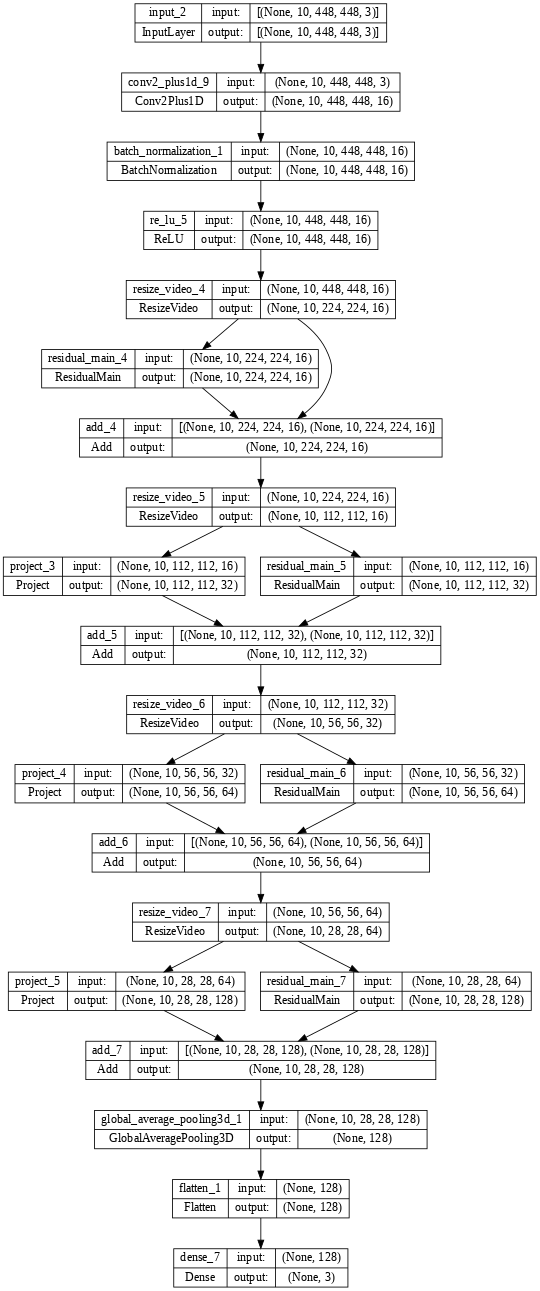

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

We choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

We use class weights and callback to train the model.

In [ ]:
class_weight = {0: 7.392441860465116, 1: 1.2214217098943323, 2: 21.735042735042736}

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x = train_ds,
                    epochs = 100, 
                    validation_data = val_ds,
                    callbacks=[callback],
                    class_weight=class_weight)

In [ ]:
# save the model
version = 4
MODEL_FOLDER = '/content/drive/MyDrive/ITC_Bundesliga/resnet2dplus1'
model_name = '_'.join(['resnet2dplus1', str(version)])
model_path = os.path.join(MODEL_FOLDER, model_name)

model.save(model_path)

### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

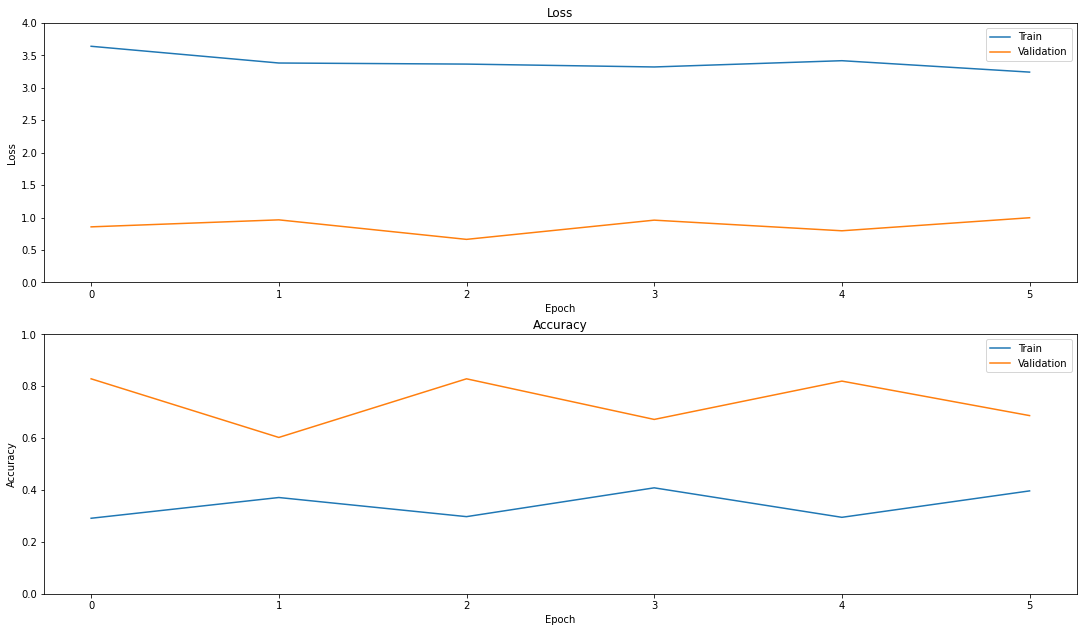

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

In [ ]:
model.evaluate(test_ds, return_dict = True)

21/21 [==============================] - 71s 3s/step - loss: 1.0370 - accuracy: 0.1733


{'loss': 1.0370081663131714, 'accuracy': 0.17331288754940033}

In [ ]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
labels = ['challenge', 'play', 'throwin']

96/96 [==============================] - 312s 3s/step


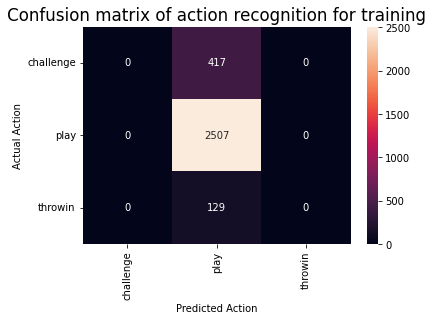

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

21/21 [==============================] - 66s 3s/step


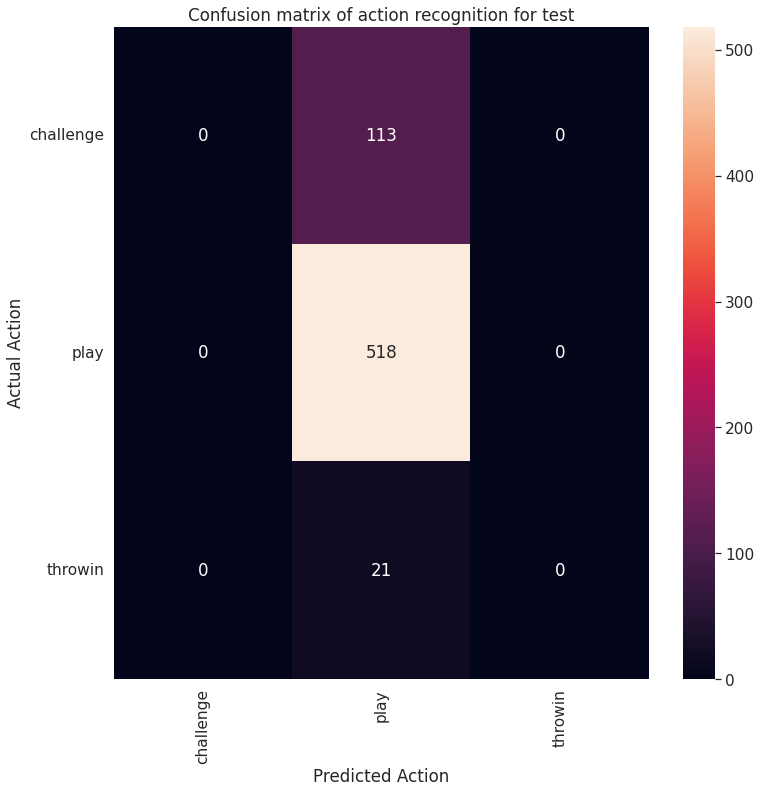

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix. 

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
recall